# Amazon Fine Food Reviews

This notebook follows [this article](https://datascienceplus.com/scikit-learn-for-text-analysis-of-amazon-fine-food-reviews/) on text classification for predicting positivity using Scikit-Learn.

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samcoffey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/samcoffey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Setup

In [2]:
#--------------------------------------------------------------------------------
# Set DATA_LOCAL to True if data is stored locally in '/data', otherwise set False
# and file will be downloaded from S3
#
# NOTE: Importing data from URL will take ~15-20s
#
#
DATA_LOCAL = True
LOCAL_PATH = "../data/"
REMOTE_PATH = "https://s3.amazonaws.com/coetichr/AmazonFoodReviews/"
NROWS = 10000
DROP_COLS = ["ProductId", "UserId", "ProfileName", "Time", "Summary", "HelpfulnessDenominator", "HelpfulnessNumerator"]
TOKENIZER = nltk.word_tokenize 

def load_data(file):
    path = LOCAL_PATH if DATA_LOCAL else REMOTE_PATH
    return pd.read_csv(path + file, nrows = NROWS)
#
#
#--------------------------------------------------------------------------------

### Load  `Reviews.csv`

In [3]:
# Load Reviews.csv
df = load_data("Reviews.csv")

# Print the first 5 lines
print("Number of rows: " + str(df.shape[0]))
df.head()

Number of rows: 10000


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Cleaning

#### Add Classification Column (Positivity)

- Remove rows with neutral score ('Score' = 3)
- Remove unhelpful reviews ('HelpfulnessNumerator' = 0)
- Remove unneeded columns specified by `DROP_COLS` above
- Add 'Positivity' column ('Score' = { [1,2] => 0, [4,5] => 1 })

In [4]:
df.dropna(inplace=True)
df = df[df['Score'] != 3]
df = df[df['HelpfulnessNumerator'] != 0]
df.drop(columns = DROP_COLS, inplace = True, axis = 1)
df['Positivity'] = np.where(df['Score'] > 3, 1, 0)
print("Number of rows: " + str(df.shape[0]))
df.head()

Number of rows: 4141


,Id,Score,Text,Positivity
0,1,5,I have bought several of the Vitality canned d...,1
2,3,4,This is a confection that has been around a fe...,1
3,4,2,If you are looking for the secret ingredient i...,0
8,9,5,Right now I'm mostly just sprouting this so my...,1
10,11,5,I don't know if it's the cactus or the tequila...,1


### Split into Training and Test

Split data into random training and test subsets using "Text" and "Positivity" columns

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(df['Text'], df['Positivity'], random_state = 0)
print('X_train row count: ', X_train.shape[0])
print('Y_train row count: ', Y_train.shape[0])

X_train row count:  3105
Y_train row count:  3105


### Token Distribution

Determine how token frequency is distributed in the corpus

In [6]:
SKIP_WORDS = ['/><br', '-', '_', '/>I']

# Method for processing review text to remove punctuation and stopwords &
# returns list of cleaned text
def process_text(review_text):
    no_punc_text = review_text.translate(string.punctuation)
    return [word for word in no_punc_text.split() if word.lower() not in (stopwords.words('english') + SKIP_WORDS)]

# Determine the most frequently used words in the corpus
def token_count_df(dataframe, columnname):
    words = Counter()
    for idx in dataframe.index:
        words.update(process_text(dataframe.loc[idx, columnname]))
    token_df = pd.DataFrame.from_dict(words, orient = 'index').reset_index()
    token_df = token_df.rename(columns = {'index': 'token', 0: 'count'})
    token_df = token_df.sort_values('count', ascending = False)
    return token_df

# Plot the given dataframe representing the distribution of token counts
def plot_token_df(token_df, title = 'Token Count Distribution'):
    plt.subplots(figsize = (14,10))
    sns.barplot(x = token_df['count'], y = token_df['token'], palette = "deep").set_title(title)
    plt.show()

### Token Distribution

Create a dataframe with the token distribution (using `process_text` from above to create a clean tokenization of each review string)

In [7]:
token_dataframe = token_count_df(df, 'Text')
token_dataframe.head(10)

,token,count
12,like,1782
103,one,1064
8,good,1033
142,taste,911
227,would,901
836,coffee,856
235,great,805
10,product,740
89,love,718
129,really,707


**Token Distribution Bar Chart:**

This represents the top 25 most frequent tokens in the corpus (*after cleaning out stopwords, puncuation, etc.*)

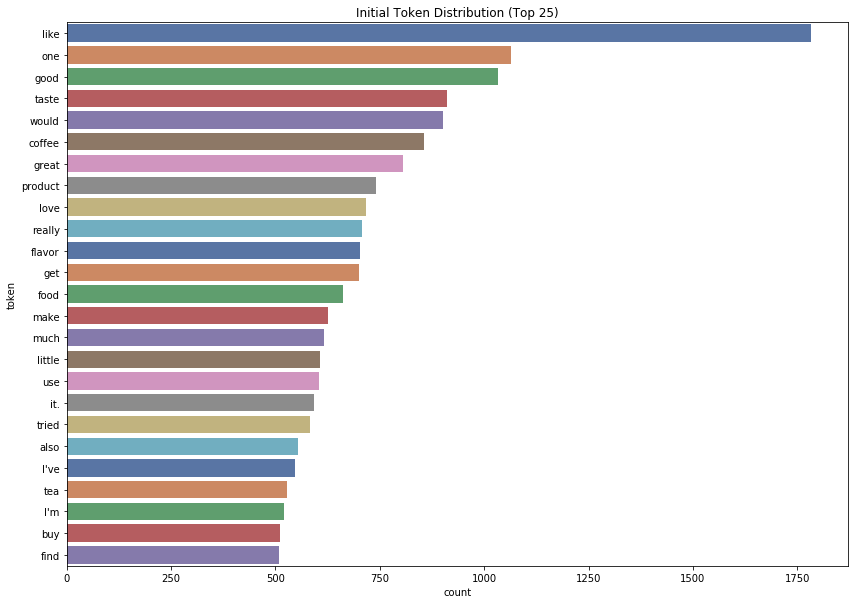

In [8]:
plot_token_df(token_dataframe.head(25), 'Initial Token Distribution (Top 25)')

### Token Distribution - Positive Reviews

Create dataframe like above with token counts with only the positive reviews

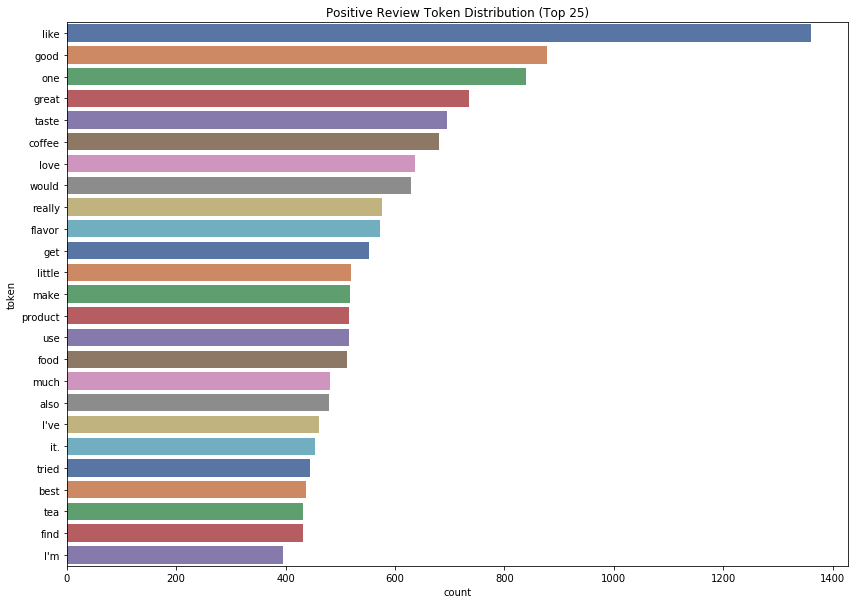

In [9]:
pos_df = df[df['Positivity'] == 1]
pos_tok_df = token_count_df(pos_df, 'Text')
plot_token_df(pos_tok_df.head(25), 'Positive Review Token Distribution (Top 25)')

### Token Distribution - Negative Reviews

Create dataframe like above with token counts with only the negative reviews

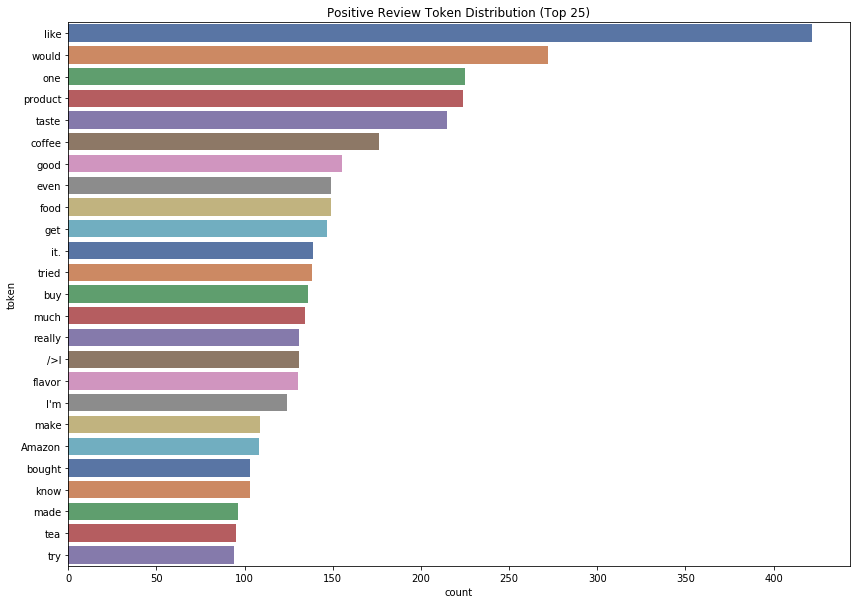

In [10]:
neg_df = df[df['Positivity'] == 0]
neg_tok_df = token_count_df(neg_df, 'Text')
plot_token_df(neg_tok_df.head(25), 'Negative Review Token Distribution (Top 25)')

In [11]:
vect = CountVectorizer(min_df = 10, ngram_range = (1,3), analyzer = 'word', token_pattern = r'\w{1,}', lowercase = True).fit(X_train)
X_train_vectorized = vect.transform(X_train)

### Features

Get the number of features being used by the vectorizer

In [12]:
print("Number of features: " + str(len(vect.get_feature_names())))

Number of features: 6327


### Create the Model

Create logistic regression model, run predictions, and compute the AUC score:

In [13]:
model = LogisticRegression()
model.fit(X_train_vectorized, Y_train)
predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(Y_test, predictions))

AUC:  0.7811265181111428


### Confusion Matrix

Plot confusion matrix to visualize classifier performance

- **Bottom Left** - False Negative
- **Top Left** - True Negative
- **Top Right** - False Positive
- **Bottom Right** - True Positive

Accuracy score = (true positives + true negatives) / (false positives + false negatives)

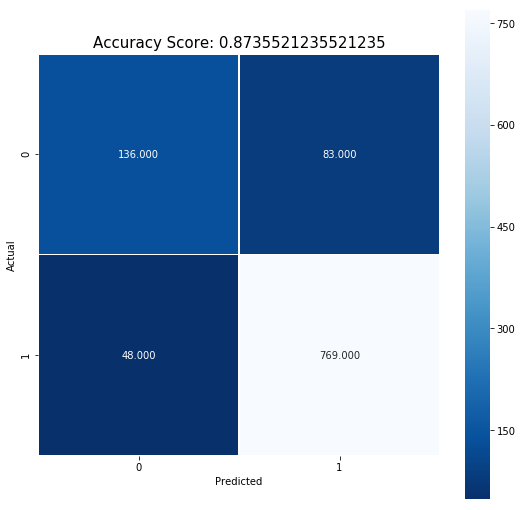

In [14]:
def plot_confusion_matrix(xtest, ytest, preds):
    cm = confusion_matrix(ytest, preds)
    score = model.score(xtest, ytest)
    plt.figure(figsize = (9,9))
    sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    title = 'Accuracy Score: {0}'.format(score)
    plt.title(title, size = 15)
    
plot_confusion_matrix(vect.transform(X_test), Y_test, predictions)

### Top Features

Print out the features with the smallest coefficients (most negative), and the features with the largest coefficients (most positive)

In [15]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:20]))
print('Largest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:-21:-1]))

Smallest Coef: 
['disappointed' 'disappointing' 'unfortunately' '00' 'worst' 'would not'
 'that is' 'weak' 'item' 'might' 'sour' 'return' 'stick' 'ok' 'not worth'
 'terrible' 'cheap' 'not' 'waste' 'and was']

Largest Coef: 
['great' 'excellent' 'delicious' 'not too' 'best' 'perfect' 'amazing'
 'i like' 'smooth' 'snack' 'good' 'highly' 'our' 'loves' 'nice' 'keep'
 'love' 'yummy' 'use' 'happy']



### Make a Prediction

Test the model with some custom review text

In [16]:
prediction_text = "I might get this candy again"
prediction = model.predict(vect.transform([prediction_text]))[0]

print("Text to predict:\n\n" + prediction_text + "\n")

if prediction:
    print("Prediction ==> POSITIVE")
else:
    print("Prediction ==> NEGATIVE")

Text to predict:

I might get this candy again

Prediction ==> POSITIVE
